In [125]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Embedding,Input,Dense,Conv1D,MaxPooling1D,Dense,Flatten,Lambda,LSTM
from keras import backend as K
import tensorflow as tf
import pandas as pd
import numpy as np
import jieba
import time
from IPython.core.interactiveshell import InteractiveShell as IS
IS.ast_node_interactivity='all'
# 停词表

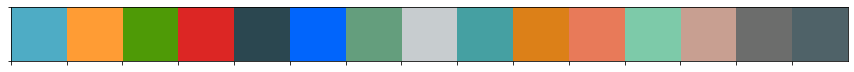

In [264]:
import plotly.graph_objs as go
import plotly
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell as IS
IS.ast_node_interactivity='all'
import matplotlib.pyplot as plt
from matplotlib import pylab
from sklearn.dummy import DummyClassifier
from sklearn.decomposition import PCA
#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier,XGBRFRegressor

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score,learning_curve,StratifiedKFold,KFold
import warnings
from sklearn.metrics import r2_score,accuracy_score,roc_auc_score,auc,f1_score,recall_score
warnings.filterwarnings('ignore')
color_lst = ['#4EACC5', '#FF9C34', '#4E9A06','#dc2624', '#2b4750','#0165fc','#649E7D', '#c7cccf', '#45a0a2',  '#dc8018','#e87a59',
         '#7dcaa9',  '#C89F91', 
         '#6c6d6c', '#4f6268']
sns.palplot(color_lst)

# 数据读取 

In [133]:
df=pd.read_csv('D://IDEA//情感分析论文/论文数据/最终论文数据.csv',index_col='created_at',parse_dates=True)
df.head()
df.shape

,content,location_map_info,city,province,score,emotion_num,related,period
created_at,,,,,,,,
2019-12-01 00:09:00,HAPPY HOMECOMING,"104.67524,29.538946",内江市,四川省,4.0,1,0,1
2019-12-01 01:51:44,刚不小心被狗咬了一口🐶 请问需要打狂犬疫苗么～,"118.653564,34.91798",临沂市,山东省,-1.7,5,0,1
2019-12-01 04:51:51,不失眠但多梦 算不上早睡但绝对是早起,"131.152542,44.412312",牡丹江市,黑龙江省,2.0,8,0,1
2019-12-01 08:36:27,12月你好,"131.1525458345,44.412310280301",牡丹江市,黑龙江省,2.2,2,0,1
2019-12-01 08:42:15,外面看着好冷清,"119.303543,26.078131",福州市,福建省,-2.0,2,0,1


(354508, 8)

# 根据jieba分词,仅以空格分开

In [41]:
# 根据词库分词
jieba.load_userdict("70000-dict.txt")
def divide_word(df,column='content'):
    seg_list = jieba.cut(df[column], cut_all=False)
    return " ".join(seg_list)

In [42]:
%%time
data=df.copy()
data['content'] = data.apply(divide_word,axis = 1)
texts = data['content'].values
print('Found %s texts.' % len(texts))

Found 354508 texts.
Wall time: 1min 11s


## 将texts中出现过的词组成词库word_index
sequences 为texts转化后的序号表示

In [43]:
%%time
MAX_SEQUENCE_LENGTH = 200 #样本最长369，可以测试更长的数据
EMBEDDING_DIM = 200 #腾讯的维度，不能修改

# 将字符转化为序号,并分开
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# 词库：字典，序号从1开始
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 168876 unique tokens.
Wall time: 19 s


In [44]:

texts[0]
sequences[0]
texts[1]
df['content'].values[1]

'HAPPY   HOMECOMING  '

[10320, 96457]

'刚 不小心 被狗 咬了一口 🐶   请问 需要 打 狂犬疫苗 么 ～  '

'刚不小心被狗咬了一口🐶 请问需要打狂犬疫苗么～ '

In [10]:
pd.DataFrame(texts).to_csv('论文数据/texts.csv',index=False)

In [11]:
pd.DataFrame(sequences).to_csv('论文数据/sequences.txt',index=False)

## 读取词向量库

In [45]:
%%time
embeddings_index = {}
# key 为词，value为向量表示
with open('45000-small.txt','r',encoding='UTF-8') as f:
    for i,line in enumerate(f):
        if i == 0:
            continue
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
print('Found %s word vectors.' % len(embeddings_index))

Found 45000 word vectors.
Wall time: 2.78 s


## 从词向量库提取向量对应content的词向量库
word_index是content的词库，字典形式，key:字符,value:序号,1开始


embedding_index是词向量库，字典形式，key:字符,value:词向量

embedding_matrix是content对应后的词向量库

word_vector是content的词向量库，key:序号1开始,value:向量


之所以用序号做key，是因为sequence已被转化为序号的集合

In [46]:
embedding_matrix = np.zeros((len(word_index), EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i-1] = embedding_vector

In [47]:
word_vector=dict(zip(np.arange(1,embedding_matrix.shape[0]+1),embedding_matrix))

In [17]:
len(sequences[0])
len(sequences[1])
word_vector.get(3).shape

2

11

(200,)

## 将每个content包含的词向量取均值

In [48]:
%%time
content_vetor=np.zeros((len(sequences),EMBEDDING_DIM))
for i,data_i in enumerate(sequences):
    _vetor_array=np.zeros(EMBEDDING_DIM)
    # data_i 表示一个content
    for j in data_i:
        # j 为每个content包含的序号
        _vetor=word_vector.get(j)
        if _vetor is not None:
            _vetor_array+=_vetor
    content_vetor[i]=_vetor_array/len(data_i)
    

Wall time: 16.3 s


# 标签数据

In [134]:
data=df['2019-12-31':'2020-02-23']
data.head()

,content,location_map_info,city,province,score,emotion_num,related,period
created_at,,,,,,,,
2019-12-31 01:36:43,我分享了文章洋葱是蔬菜皇后…… 钟南山：支架！让生命进入倒计时,"117.353729,39.731544",天津市,天津市,9.2,17,0,1
2019-12-31 02:10:56,刚刚学会excle的函数VLOOKUP，可把我🐮B坏了！！！叉会腰[酷][酷][酷] 三个小...,"116.414775,39.910965",北京市,北京市,-2.2,36,0,1
2019-12-31 04:40:52,趁着疫苗有效期 我爱你猫,"125.390442,43.796951",长春市,吉林省,-0.3,3,0,1
2019-12-31 05:22:09,2019最后一天了，加油＾０＾~,"127.172182,44.586528",吉林市,吉林省,12.4,8,0,1
2019-12-31 06:02:14,住院第三十天。 给自己和宝宝加油，爸爸和很多关心我们的人在等着我们完成今天的所有操作，凯旋而...,"116.416061,39.913582",北京市,北京市,22.0,38,0,1


In [84]:
a=pd.DataFrame(content_vetor)

In [96]:
# 和data匹配
vector=a[(df.index>='2019-12-31')&(df.index<'2020-02-24')]
vector.index=data.index
vector.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
created_at,,,,,,,,,,,,,,,,,,,,,
2019-12-31 01:36:43,0.208890,-0.310368,-0.022426,0.181346,0.104089,-0.005829,0.053153,0.114983,0.144577,0.202922,...,0.099621,0.134938,0.102078,-0.020152,0.169218,0.315875,0.139410,-0.271119,-0.194817,0.108773
2019-12-31 02:10:56,0.143632,-0.201014,-0.002247,0.076406,0.121863,-0.015342,0.033045,0.044507,0.086376,0.130168,...,0.103452,0.073922,0.019178,-0.047573,0.122434,0.281119,0.043988,-0.161373,-0.137274,0.068035
2019-12-31 04:40:52,0.315573,-0.322999,-0.065702,0.110107,0.092705,0.247010,0.108960,0.155297,0.010627,-0.050202,...,0.136547,0.121713,-0.007129,-0.160896,0.039185,0.434827,0.028972,-0.234969,-0.308386,0.087896
2019-12-31 05:22:09,-0.077624,-0.152944,-0.113369,0.164475,0.165110,-0.013126,0.045473,0.075506,0.008647,0.056379,...,0.094309,0.143277,-0.010588,-0.125409,0.020278,0.218151,0.000649,-0.108630,-0.107405,-0.021225
2019-12-31 06:02:14,0.101356,-0.201655,-0.114816,0.190558,0.129149,0.025798,0.034289,0.058992,0.118720,0.094229,...,0.164988,0.091231,0.027006,-0.079551,0.118978,0.246056,0.084212,-0.161702,-0.205749,0.071236


In [136]:
data_lst=[]
vector_lst=[]
for i in range(2,5):
    np.random.seed(100)
    _data=data[data.period==i]
    _vector=vector[data.period==i]
    num_th=np.random.randint(0,len(_data),size=200)
    vector_lst.append(_vector.iloc[num_th.tolist(),:])
    data_lst.append(_data.iloc[num_th.tolist(),:])
_=pd.concat(data_lst,axis=0)
_.head()

,content,location_map_info,city,province,score,emotion_num,related,period
created_at,,,,,,,,
2020-01-25 12:58:00,太好了，中国加油，医生护士真的很伟大🙏,"116.505646,31.768353",六安市,安徽省,2.5,7,0,2
2020-01-23 08:56:00,不传谣！,"117.01339,25.024303",龙岩市,福建省,-0.1,1,0,2
2020-01-23 03:34:00,一直到现在就没有睡着过，，封城了，居然，，。瑟瑟发抖……,"114.354537,30.578143",武汉市,湖北省,-3.5,14,0,2
2020-01-20 08:32:00,太难了。,"119.303543,26.078131",福州市,福建省,0.3,2,0,2
2020-01-23 12:28:00,菏泽市立医︀院发︄热门诊位︃置： 医院东北角全科医师培训︇基地一楼南侧。 有发︍烧请直︊接去...,"115.425634,35.238715",菏泽市,山东省,4.0,37,1,2


In [137]:
_1=pd.read_csv('无标签.csv')
machine_data=pd.concat(vector_lst)
machine_data['temp']=_1['Unnamed: 2'].values.tolist()
machine_data['related']=_['related'].values.tolist()
machine_data.head()

,0,1,2,3,4,5,6,7,8,9,...,192,193,194,195,196,197,198,199,temp,related
created_at,,,,,,,,,,,,,,,,,,,,,
2020-01-25 12:58:00,0.113078,-0.147917,-0.059400,0.178280,0.132715,0.000420,-0.000697,-0.006793,0.100441,0.043158,...,-0.013166,0.006354,0.100178,0.083665,-0.010538,-0.094326,-0.071283,0.106201,0,0
2020-01-23 08:56:00,0.110202,-0.278002,-0.138825,0.169594,0.056677,-0.082294,-0.008428,0.012434,0.130233,0.166085,...,-0.015675,-0.162728,0.133477,0.292923,0.101574,-0.250131,-0.142645,-0.016696,0,0
2020-01-23 03:34:00,0.225870,-0.166002,0.040290,0.113796,0.211800,-0.018911,0.072391,0.006141,0.129353,0.117697,...,-0.011950,-0.004915,0.063183,0.209848,0.021897,-0.201821,-0.148373,0.015953,1,0
2020-01-20 08:32:00,0.295728,-0.223052,0.017726,0.229398,0.225802,0.042607,0.101522,0.011808,0.109016,0.094274,...,-0.002435,-0.085668,0.163477,0.365657,0.097690,-0.135934,-0.234329,0.059426,0,0
2020-01-23 12:28:00,0.157607,-0.163905,-0.048314,0.128537,0.003021,0.007202,0.015112,0.022043,0.082498,0.065426,...,0.102841,-0.036715,0.077600,0.228674,0.007062,-0.137238,-0.151757,0.073135,0,1


In [138]:
machine_data.to_csv('论文数据/机器学习判别.csv')

In [227]:
# 第二套数据
data_lst=[]
vector_lst=[]
for i in range(1,5):
    np.random.seed(200)
    _data=data[data.period==i]
    _vector=vector[data.period==i]
    num_th=np.random.randint(0,len(_data),size=100)
    vector_lst.append(_vector.iloc[num_th.tolist(),:])
    data_lst.append(_data.iloc[num_th.tolist(),:])
_=pd.concat(data_lst,axis=0)
_.head()

,content,location_map_info,city,province,score,emotion_num,related,period
created_at,,,,,,,,
2020-01-04 22:00:00,,"116.41606,39.91358",北京市,北京市,0.0,0,0,1
2020-01-07 12:27:00,一个人吃饭好难啊！,"131.152542,44.412312",牡丹江市,黑龙江省,1.7,3,0,1
2020-01-07 18:44:00,❤️广州 hpv 9价❤️,"113.318985,23.058409",广州市,广东省,3.1,3,0,1
2020-01-08 12:01:00,想了很久的糖葫芦，吃一口酸到吐🤮…,"131.152542,44.412312",牡丹江市,黑龙江省,-2.6,4,0,1
2020-01-12 22:45:00,汉刺青1月18号开始休年假。 春节2月4号复工。 [抱拳][抱拳][抱拳],"121.458029,31.220428",上海市,上海市,2.0,9,0,1


In [228]:
_2=pd.read_csv('无标签2.csv')
machine_data2=pd.concat(vector_lst)
machine_data2['temp']=_2['Unnamed: 2'].values.tolist()
machine_data2['related']=_['related'].values.tolist()
machine_data2.head()

,0,1,2,3,4,5,6,7,8,9,...,192,193,194,195,196,197,198,199,temp,related
created_at,,,,,,,,,,,,,,,,,,,,,
2020-01-04 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2020-01-07 12:27:00,0.209975,-0.306662,-0.015880,0.088588,0.088637,-0.036426,-0.000269,0.079854,0.161293,0.026593,...,-0.129182,-0.111271,0.155557,0.378557,-0.055901,-0.213752,-0.189623,0.082097,0,0
2020-01-07 18:44:00,0.066851,-0.176622,-0.050371,0.068808,0.055876,-0.016443,0.039084,0.102588,-0.028842,0.022864,...,0.051374,-0.027768,0.045499,0.159299,0.048267,-0.097481,-0.035512,-0.007728,0,0
2020-01-08 12:01:00,0.078945,-0.146531,-0.029834,0.052599,0.026693,-0.018519,0.032179,-0.019988,0.149954,0.082876,...,-0.019073,-0.042302,0.039315,0.250804,0.010130,-0.061564,-0.125393,0.044364,0,0
2020-01-12 22:45:00,0.229496,-0.150132,-0.037659,0.299816,0.132153,-0.067479,0.149344,0.146940,-0.067626,0.154269,...,0.015781,-0.192042,0.082874,0.418648,-0.029192,-0.080364,-0.197405,-0.013136,0,0


In [241]:
machine_data2.to_csv('论文数据/机器学习判别2.csv')

# 读取数据

In [244]:
machine_data=pd.read_csv('论文数据/机器学习判别.csv',index_col=['created_at'],parse_dates=True)
machine_data2=pd.read_csv('论文数据/机器学习判别2.csv',index_col=['created_at'],parse_dates=True)
machine_data=pd.concat([machine_data,machine_data2],axis=0)
machine_data.dropna(inplace=True)
machine_data['temp'].replace(11,1,inplace=True)

In [245]:
machine_data['related'].mean()

0.6810865191146881

# 降维

In [246]:
pca=PCA(n_components=50)
X=pca.fit_transform(machine_data.values[:,:-2])
pca.explained_variance_ratio_.sum()

0.7922121169700745

In [280]:
y=machine_data.iloc[:,-2]
y1=machine_data.iloc[:,-1]

In [248]:
Xtrain,Xtest,ytrain,ytest=train_test_split(X,y,test_size=0.3,random_state=32)
Xtrain1,Xtest1,ytrain1,ytest1=train_test_split(X,y1,test_size=0.3,random_state=32)

## SVM训练基于ROC

In [249]:
# %%time

model=svm.SVC(probability=True)
model=model.fit(Xtrain,ytrain)

accuracy_score(ytrain,model.predict(Xtrain))
accuracy_score(ytrain,ytrain1)
ytrain.mean()
print('__________________________________')
accuracy_score(ytest,model.predict(Xtest))
accuracy_score(ytest,ytest1)
ytest.mean()

0.8805755395683453

0.7784172661870503

0.6575539568345323

__________________________________


0.7792642140468228

0.7692307692307693

0.6387959866220736

## DummyClass

In [168]:
dum=DummyClassifier()
dum=dum.fit(Xtrain,ytrain)
accuracy_score(ytest,dum.predict(Xtest))

0.5611111111111111

## gamma

In [253]:
gamma_range = np.linspace(1, 3, 25)
roc_lst=[]
acc_lst=[]
for i in gamma_range:
    clf= svm.SVC(kernel = 'rbf',probability=True,gamma=i).fit(Xtrain,ytrain)
    roc_lst.append(roc_auc_score(ytest,clf.predict_proba(Xtest)[:,1]))
    acc_lst.append(accuracy_score(ytest,clf.predict(Xtest)))
max(acc_lst)
max(roc_lst)

0.782608695652174

0.8187415163854954

3

1.25

1

25

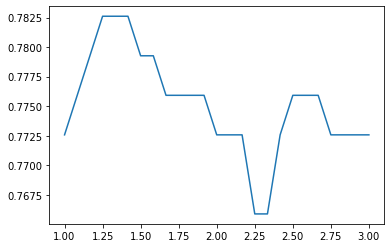

In [255]:
th=acc_lst.index(max(acc_lst))
th
gamma_range[th]
roc_lst.index(max(roc_lst))
plt.plot(gamma_range,acc_lst)
len(gamma_range)

## C惩罚项

In [256]:
C_range = np.linspace(1,5,10)
roc_lst=[]
acc_lst=[]
for i in C_range:
    clf= svm.SVC(kernel = 'rbf',probability=True,C=i,gamma=1.25).fit(Xtrain,ytrain)
    roc_lst.append(roc_auc_score(ytest,clf.predict_proba(Xtest)[:,1]))
    acc_lst.append(accuracy_score(ytest,clf.predict(Xtest)))
max(acc_lst)
max(roc_lst)

0.7926421404682275

0.8176992437463642

1.4444444444444444

1.0

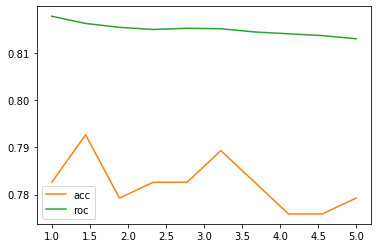

In [257]:
C_range[np.argmax(acc_lst)]
C_range[np.argmax(roc_lst)]
plt.plot(C_range,acc_lst,'C1',label='acc')
plt.plot(C_range,roc_lst,'C2',label='roc')
plt.legend()

## 所有指标

In [281]:
y2=[1]*len(y)

In [286]:
model=svm.SVC(kernel = 'rbf',probability=True,C=1.444,gamma=1.25)
model=model.fit(Xtrain,ytrain)
print('acc')
accuracy_score(ytrain,model.predict(Xtrain))
accuracy_score(ytest,model.predict(Xtest))
accuracy_score(y,y1)
accuracy_score(y,y2)
print('roc')
roc_auc_score(ytrain,model.predict_proba(Xtrain)[:,1])
roc_auc_score(ytest,model.predict_proba(Xtest)[:,1])
print('f1')
f1_score(ytrain,model.predict(Xtrain))
f1_score(ytest,model.predict(Xtest))
f1_score(y,y1)
f1_score(y,y2)
print('recall')
recall_score(ytrain,model.predict(Xtrain))
recall_score(ytest,model.predict(Xtest))
recall_score(y,y1)
recall_score(y,y2)
print('cross')
cross_val_score(model,X,y,cv=10,scoring='accuracy').mean()
cross_val_score(model,X,y,cv=10,scoring='roc_auc').mean()
cross_val_score(model,X,y,cv=10,scoring='f1').mean()
cross_val_score(model,X,y,cv=10,scoring='recall').mean()

acc


0.8906474820143885

0.7926421404682275

0.7756539235412475

0.6519114688128773

roc


0.9571787139363405

0.8161721931355439

f1


0.921161825726141

0.845

0.8316981132075472

0.7892813641900123

recall


0.9715536105032823

0.8848167539267016

0.8503086419753086

1.0

cross


0.7947676767676768

0.8478515675500968

0.8496444507632817

0.893389423076923

In [287]:
model=svm.SVC(kernel = 'rbf',probability=True,C=1.444,gamma=1.25)
model=model.fit(Xtrain,ytrain)
print('acc')
cross_val_score(model,X,y,cv=10,scoring='accuracy').mean()
accuracy_score(y,y1)
accuracy_score(y,y2)

print('f1')
cross_val_score(model,X,y,cv=10,scoring='f1').mean()
f1_score(y,y1)
f1_score(y,y2)

print('recall')
cross_val_score(model,X,y,cv=10,scoring='recall').mean()
recall_score(y,y1)
recall_score(y,y2)

acc


0.7947676767676768

0.7756539235412475

0.6519114688128773

f1


0.8496444507632817

0.8316981132075472

0.7892813641900123

recall


0.893389423076923

0.8503086419753086

1.0

# 最终分类数据集

In [335]:
null_condition=[len(i)!=0 for i in sequences]

In [338]:
pca=PCA(n_components=50)
X_all=pca.fit_transform(content_vetor[null_condition])
pca.explained_variance_ratio_.sum()

0.741581073728724

In [342]:
model=svm.SVC(kernel = 'rbf',probability=True,C=1.444,gamma=1.25)
model.fit(X,y)
y_all=model.predict(X_all)

SVC(C=1.444, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1.25, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [344]:
data=df[null_condition]
data['machine']=y_all
data.to_csv('论文数据/机器学习最终数据.csv')

# 模型集合预测

In [276]:
%%time
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifier(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(kernel = 'rbf',probability=True,C=1.444,gamma=1.25),
    svm.NuSVC(),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    XGBClassifier()    
    ]

cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3) # run model 10x with 60/30 split intentionally leaving out 10%

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = y.copy()

#index through MLA and save performance to table
row_index = 0
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(alg, X,y, cv  = cv_split,return_train_score=True)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
    
    MLA_compare.loc[row_index,'Keys_train']=accuracy_score(ytrain,ytrain1)
    MLA_compare.loc[row_index,'Keys_test']=accuracy_score(ytest,ytest1)
    row_index+=1

MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare


Wall time: 25 s


,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time,Keys_train,Keys_test
14,SVC,"{'C': 1.444, 'break_ties': False, 'cache_size'...",0.88446,0.795318,0.0591548,0.109511,0.778417,0.769231
15,NuSVC,"{'break_ties': False, 'cache_size': 200, 'clas...",0.893094,0.78495,0.0489587,0.0265274,0.778417,0.769231
6,LogisticRegressionCV,"{'Cs': 10, 'class_weight': None, 'cv': None, '...",0.80705,0.770234,0.0741457,0.296018,0.778417,0.769231
9,SGDClassifier,"{'alpha': 0.0001, 'average': False, 'class_wei...",0.788058,0.762876,0.0376622,0.00371337,0.778417,0.769231
19,LinearDiscriminantAnalysis,"{'n_components': None, 'priors': None, 'shrink...",0.801871,0.762876,0.0811965,0.00588443,0.778417,0.769231
5,GaussianProcessClassifier,"{'copy_X_train': True, 'kernel': None, 'max_it...",0.797554,0.762542,0.0726299,0.25024,0.778417,0.769231
16,LinearSVC,"{'C': 1.0, 'class_weight': None, 'dual': True,...",0.800288,0.761538,0.0674633,0.00816352,0.778417,0.769231
8,RidgeClassifier,"{'alpha': 1.0, 'class_weight': None, 'copy_X':...",0.797122,0.761204,0.0449158,0.00207245,0.778417,0.769231
3,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.988201,0.752174,0.043608,0.673836,0.778417,0.769231
4,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.998561,0.749164,0.0418528,0.257426,0.778417,0.769231


# RF

## estimators

In [306]:
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm

In [307]:
import time
a=time.time()
scorelst=[]
n_e=400
for i in tqdm(range(0,n_e,10)):
    rfc=RandomForestClassifier(n_estimators=i+1,n_jobs=-1,random_state=0)
    score=cross_val_score(rfc,X,y,cv=10).mean()
    scorelst.append(score)

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [02:34<00:00,  3.86s/it]


29

0.7665959595959596

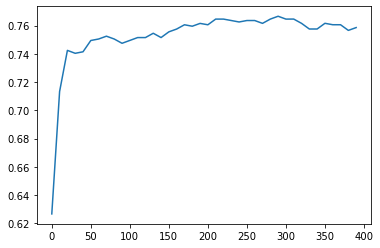

In [315]:
plt.plot(range(0,n_e,10),scorelst)
np.argmax(scorelst)
max(scorelst)
n_estimator_max=np.arange(0,n_e,10)[np.argmax(scorelst)]

## max_depth

In [311]:
from sklearn.model_selection import GridSearchCV

In [316]:
para_grid={'max_depth':np.arange(1,20,1)}
rfc=RandomForestClassifier(n_estimators=n_estimator_max,
                          random_state=90)
GS=GridSearchCV(rfc,para_grid,cv=10)
GS.fit(X,y)
GS.best_params_
GS.best_score_

GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=290, n_jobs=None,
                                              oob_score=False, random_state=90,
                                 

{'max_depth': 19}

0.7746262626262627

## features

In [317]:
%%time
para_grid={"max_features":np.arange(5,30,1)}
rfc=RandomForestClassifier(n_estimators=n_estimator_max,max_depth=19,random_state=90)
gs=GridSearchCV(rfc,para_grid,cv=10)
gs.fit(X,y)
print(gs.best_score_)
print(gs.best_params_)

0.7756868686868688
{'max_features': 11}
Wall time: 8min 20s


## min_sample

In [328]:
%%time
param_grid={'min_samples_leaf':np.arange(1, 1+10, 1)}
rfc=RandomForestClassifier(n_estimators=290,max_depth=19,max_features=11,random_state=90)
gs=GridSearchCV(rfc,param_grid,cv=10)
gs.fit(X,y)
print(gs.best_score_)
print(gs.best_params_)

0.7756868686868688
{'min_samples_leaf': 1}
Wall time: 2min


In [319]:
%%time
rfc=RandomForestClassifier(n_estimators=290,max_depth=19,max_features=11,random_state=90)
cross_val_score(rfc,X,y,cv=10).mean()

Wall time: 13.8 s


0.7756868686868688

In [329]:
model=RandomForestClassifier(n_estimators=290,max_depth=19,max_features=11,random_state=90)
print('acc')
cross_val_score(model,X,y,cv=10,scoring='accuracy').mean()
accuracy_score(y,y1)
accuracy_score(y,y2)

print('f1')
cross_val_score(model,X,y,cv=10,scoring='f1').mean()
f1_score(y,y1)
f1_score(y,y2)

print('recall')
cross_val_score(model,X,y,cv=10,scoring='recall').mean()
recall_score(y,y1)
recall_score(y,y2)

acc


0.7756868686868688

0.7756539235412475

0.6519114688128773

f1


0.8410698147500503

0.8316981132075472

0.7892813641900123

recall


0.9103846153846155

0.8503086419753086

1.0

# XGB

In [321]:
%%time
model=XGBClassifier()
para={'n_estimators':np.arange(50,400,50)}
grid_model=GridSearchCV(model,param_grid=para,cv=10,scoring='accuracy',n_jobs=-1)
grid_model.fit(X,y)
print(grid_model.best_params_)
print(grid_model.best_score_)

{'n_estimators': 200}
0.7605656565656566
Wall time: 16.6 s


In [323]:
model=XGBClassifier(n_estimators=200)
para={'learning_rate':np.arange(0,1,0.1)}
grid_model=GridSearchCV(model,cv=10,param_grid=para,scoring='accuracy',n_jobs=-1)
grid_model.fit(X,y)

print(grid_model.best_params_)
print(grid_model.best_score_)

GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_esti...
                                     objective='binary:logistic',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=Non

{'learning_rate': 0.4}
0.7606363636363637


In [326]:
model=XGBClassifier(n_estimators=200,learning_rate=0.4)
cross_val_score(model,X,y,cv=10).mean()

0.7606363636363637

In [330]:
model=XGBClassifier(n_estimators=200,learning_rate=0.4)
print('acc')
cross_val_score(model,X,y,cv=10,scoring='accuracy').mean()
accuracy_score(y,y1)
accuracy_score(y,y2)

print('f1')
cross_val_score(model,X,y,cv=10,scoring='f1').mean()
f1_score(y,y1)
f1_score(y,y2)

print('recall')
cross_val_score(model,X,y,cv=10,scoring='recall').mean()
recall_score(y,y1)
recall_score(y,y2)

acc


0.7606363636363637

0.7756539235412475

0.6519114688128773

f1


0.8256537404165064

0.8316981132075472

0.7892813641900123

recall


0.868798076923077

0.8503086419753086

1.0

In [ ]:
#Machine Learning Algorithm (MLA) Selection and Initialization
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifier(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(),
    svm.NuSVC(),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    XGBClassifier()    
    ]

# cv_split = model_selection.ShuffleSplit(n_splits = 5, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = ytrain.copy()

#index through MLA and save performance to table
row_index = 0
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(alg, Xtrain,ytrain, cv  = cv_split,return_train_score=True)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
    
    MLA_name
    #save MLA predictions - see section 6 for usage
    _=alg.fit(Xtrain, ytrain)
    MLA_predict[MLA_name] = alg.predict(Xtrain)
    
    
    row_index+=1

    
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare
#MLA_predict


In [461]:
%%time
acc_in_lst=[]
acc_out_lst=[]
guess_lst=[]
for i,_condidate in enumerate(condidate):
    y=np.where(score>_condidate,1,0).flatten()
    c=np.sum(y)/len(y)
    if c>=0.5:
        guess_lst.append(c)
    else:
        guess_lst.append(1-c)
        
    Xtrain,Xtest,ytrain,ytest=train_test_split(X,y,test_size=0.33,random_state=25)
    model=XGBClassifier()
    model=model.fit(Xtrain,ytrain)
    acc_in=accuracy_score(ytrain,model.predict(Xtrain))
    acc_out=accuracy_score(ytest,model.predict(Xtest))
    
    acc_in_lst.append(acc_in)
    acc_out_lst.append(acc_out)

Wall time: 3min 14s


In [ ]:
# fig,axes=plt.subplots(1,2)
axes=axes.flatten()
axes[0].plot(lst)
axes[0].plot(acc_in_lst)

axes[1].plot(lst)
axes[1].plot(acc_out_lst)


# CNN的思考

In [545]:
cnn_data=MinMaxScaler(feature_range=(0,255)).fit_transform(content_vetor).reshape(len(content_vetor),10,20)


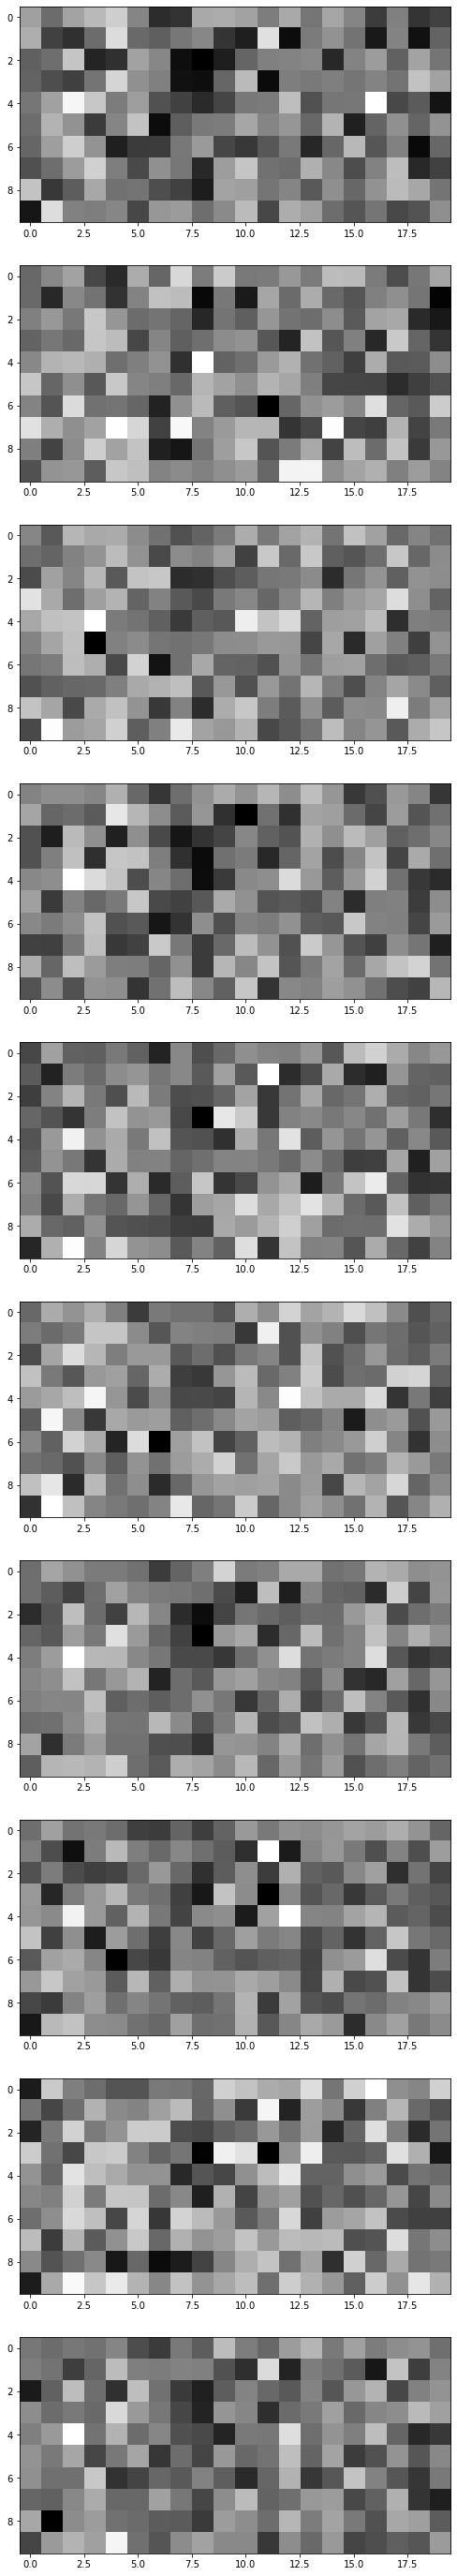

In [551]:
fig,axes=plt.subplots(10,1,figsize=(10,50))
for i,ax in enumerate(axes.flatten()):
    
    ax.imshow(cnn_data[i,:,:],cmap='gray')